T cell markers:
* https://www.rndsystems.com/cn/resources/cell-markers/immune-cells/helper-t-cells


# load data

In [1]:
##
library(Seurat)
library(tidyverse)
library(patchwork)

# library(monocle)

── Attaching packages ──────────────────────────────────────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.3     ✔ purrr   0.3.4
✔ tibble  3.0.6     ✔ dplyr   1.0.4
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.1

── Conflicts ─────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



In [2]:
setwd("/data/wangjl/scScripts/")
getwd()

[1] "/data/wangjl/scScripts"

In [3]:
dir.create("backup/a2/")
scRNA <- readRDS("backup/a1/pbmc10k_final.rds")
scRNA

Warning message in dir.create("backup/a2/"):
“'backup/a2' already exists”


An object of class Seurat 
22860 features across 10441 samples within 1 assay 
Active assay: RNA (22860 features)
 3 dimensional reductions calculated: pca, umap, tsne

In [37]:
outputRoot=paste0( getwd(), "/backup/a2/")
outputRoot

[1] "/data/wangjl/scScripts/backup/a2/"

In [4]:
levels(Idents(scRNA))

[1] "CD14+ Mono"   "Naive CD4 T"  "CD8 T"        "Memory CD4 T" "FCGR3A+ Mono"
 [6] "B"            "NK"           "DC"           "CD4+ CTL"     "?"           
[11] "Platelet"

In [5]:
levels(scRNA@active.ident)

[1] "CD14+ Mono"   "Naive CD4 T"  "CD8 T"        "Memory CD4 T" "FCGR3A+ Mono"
 [6] "B"            "NK"           "DC"           "CD4+ CTL"     "?"           
[11] "Platelet"

## 提取细胞子集

In [11]:
scRNAsub=subset(scRNA, idents = c('Naive CD4 T','CD8 T','Memory CD4 T'))
scRNAsub

An object of class Seurat 
22860 features across 4839 samples within 1 assay 
Active assay: RNA (22860 features)
 3 dimensional reductions calculated: pca, umap, tsne

# 再聚类

因为再聚类的细胞之间差异比较小，所以聚类函数FindClusters()控制分辨率的参数建议调高到resolution = 0.9。

## PCA降维

Centering and scaling data matrix

PC_ 1 
Positive:  NKG7, CST7, GZMA, CCL5, GNLY, GZMH, PRF1, HOPX, PLEK, KLRD1 
	   KLRG1, CCL4, CLIC1, FGFBP2, EFHD2, ZEB2, S100A4, CD99, FCGR3A, SH3BGRL3 
	   GZMB, TRGC2, ANXA2, ADGRG1, APOBEC3G, C12orf75, MYO1F, FCRL6, HLA-A, CTSC 
Negative:  CCR7, SELL, LEF1, TCF7, TRABD2A, RPL23, FOXP1, ACTN1, NOSIP, MAL 
	   LTB, IL7R, PRKCQ-AS1, SATB1, RPS8, IL6ST, FHIT, TXK, CD55, CHRM3-AS2 
	   AIF1, LRRN3, PDE3B, SERINC5, NELL2, NOG, RPLP0, FAM153CP, PDK1, ARMH1 
PC_ 2 
Positive:  KLRK1, CD8A, CD8B, GZMH, KLRD1, FGFBP2, CTSW, FCGR3A, GZMB, CCL4 
	   ADGRG1, GNLY, ZEB2, LINC02446, GZMM, NKG7, PLEK, FCRL6, MALAT1, PRF1 
	   PRSS23, CX3CR1, ATM, SPON2, AOAH, NUCB2, KLRF1, TTC38, CD160, FGR 
Negative:  LTB, S100A11, ITGB1, TNFRSF4, CRIP1, AQP3, TRADD, VIM, PLP2, S100A4 
	   MAF, LPAR6, FUT7, CD40LG, TNFSF10, GPR183, S100A10, LGALS3, ANXA2, CAPG 
	   TNFRSF18, TIMP1, ANXA1, TTC39C-AS1, COTL1, ADAM19, LMNA, KLF6, CD82, ALOX5AP 
PC_ 3 
Positive:  MALAT1, XIST, NEAT

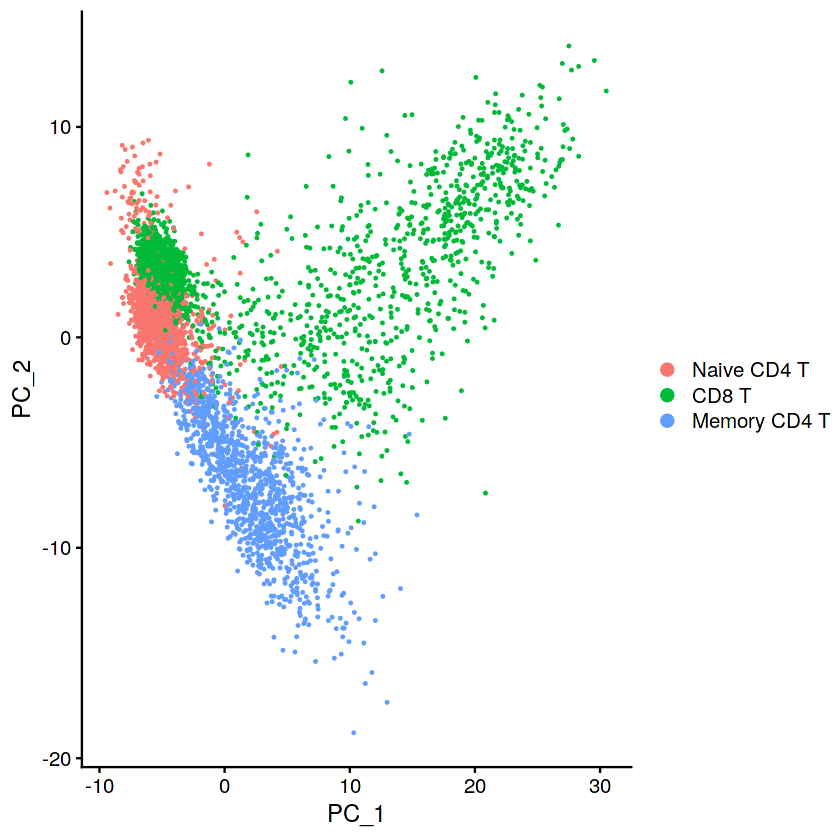

In [26]:
scRNAsub <- FindVariableFeatures(scRNAsub, selection.method = "vst", nfeatures = 2000)
scale.genes <-  rownames(scRNAsub)

scRNAsub <- ScaleData(scRNAsub, features = scale.genes)

scRNAsub <- RunPCA(scRNAsub, features = VariableFeatures(scRNAsub), npcs = 50)
DimPlot(scRNAsub, reduction = "pca")

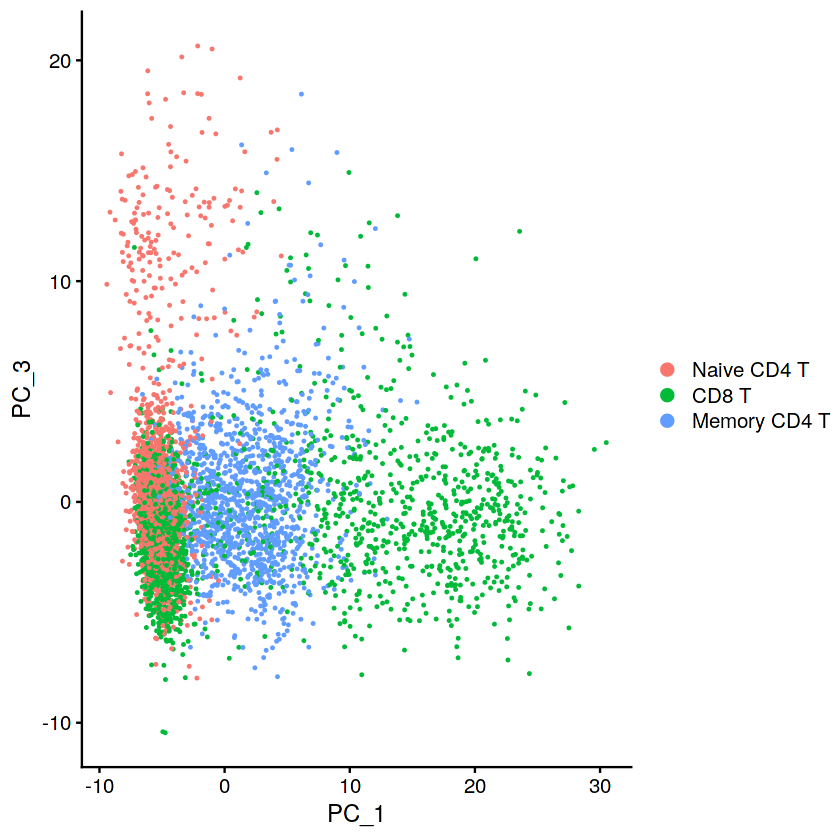

In [27]:
DimPlot(scRNAsub, reduction = "pca", dims = c(1,3))

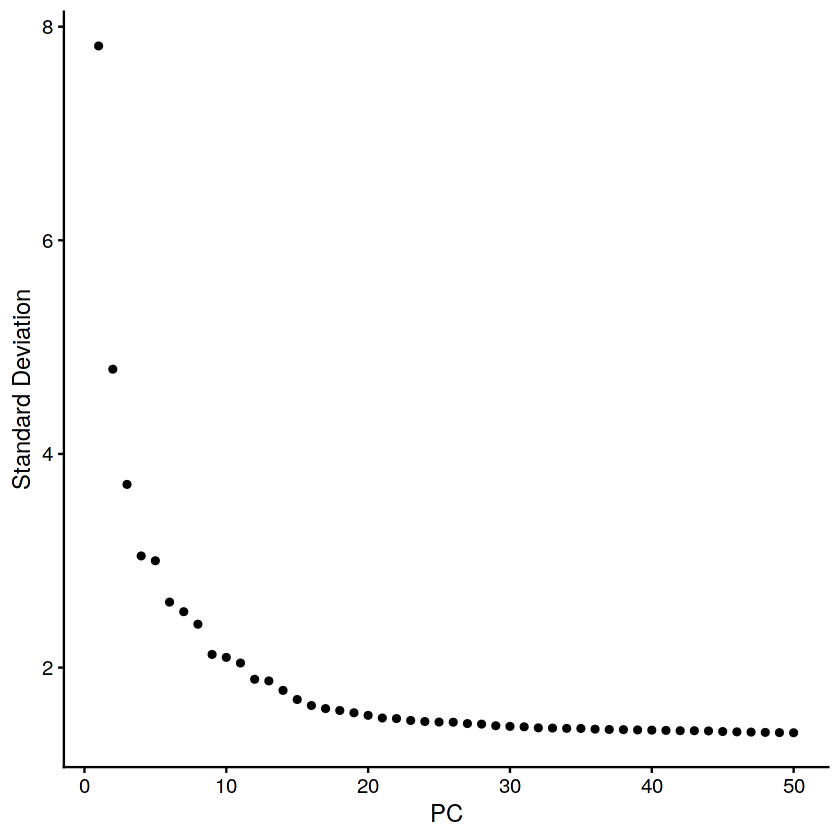

In [28]:
ElbowPlot(scRNAsub, ndims=50, reduction="pca")

In [29]:
dim(scRNAsub)

[1] 22860  4839

Warning message:
“Removed 45629 rows containing missing values (geom_point).”


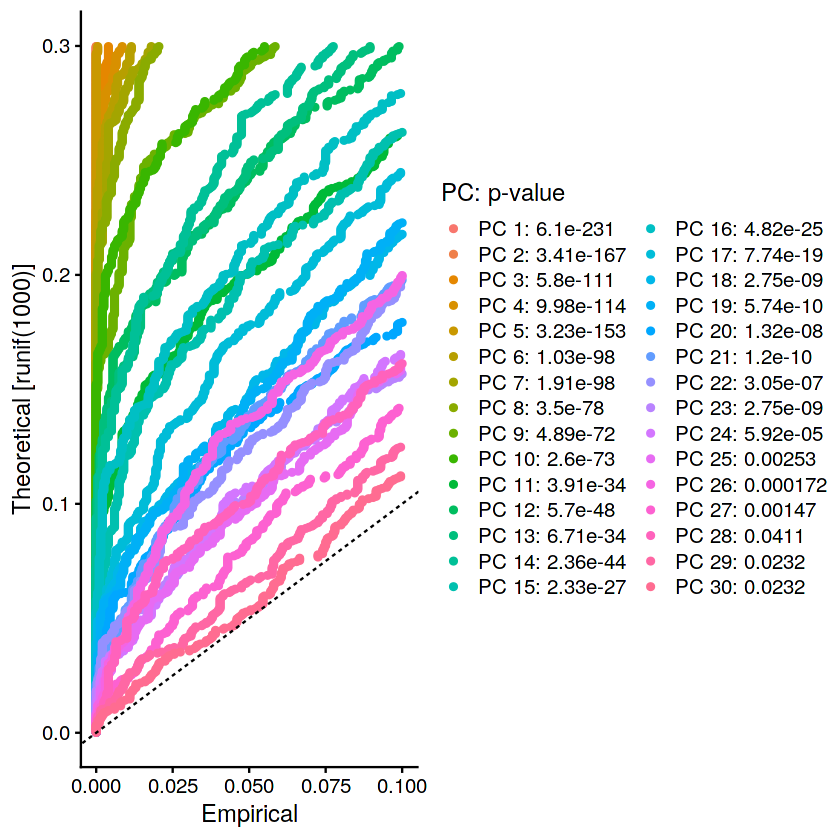

In [34]:
# long time: 15:30 - 
scRNAsub <- JackStraw(scRNAsub, dims = 50)
scRNAsub <- ScoreJackStraw(scRNAsub, dims = 1:50)
JackStrawPlot(scRNAsub, dims = 1:30)

## 细胞聚类

In [35]:
pc.num=1:30

In [36]:
##细胞聚类
scRNAsub <- FindNeighbors(scRNAsub, dims = pc.num) 
scRNAsub <- FindClusters(scRNAsub, resolution = 0.9) ### 高分辨率
table(scRNAsub@meta.data$seurat_clusters)

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 4839
Number of edges: 205774

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8041
Number of communities: 12
Elapsed time: 0 seconds



   0    1    2    3    4    5    6    7    8    9   10   11 
1059  684  643  528  375  363  292  265  198  184  166   82 

In [38]:
metadata <- scRNAsub@meta.data
cell_cluster <- data.frame(
    cell_ID=rownames(metadata), 
    cluster_ID=metadata$seurat_clusters
)

head(cell_cluster)
write.csv(cell_cluster, paste0(outputRoot, '00_cell_cluster.csv'), row.names = F)

cell_ID          cluster_ID
1 AAACCCAGTCGGTGAA 10        
2 AAACCCATCAGACAAA 0         
3 AAACCCATCCATACTT 4         
4 AAACGAACAACTCGAT 9         
5 AAACGAACACCGAATT 1         
6 AAACGAACAGACACCC 3

### 质控

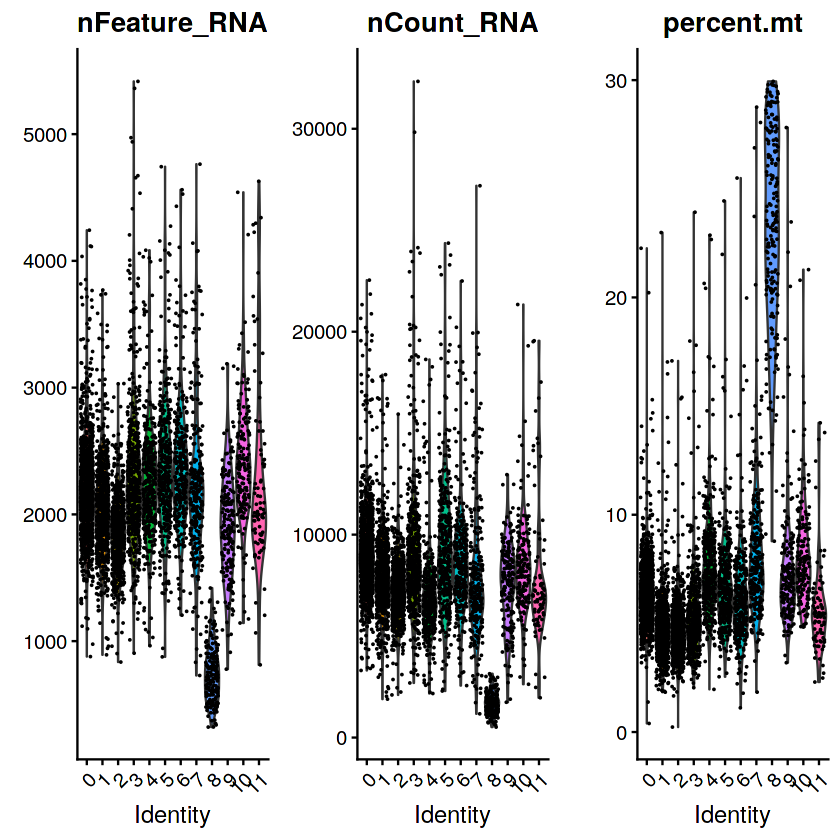

In [106]:
violin=VlnPlot(scRNAsub,
        features = c("nFeature_RNA", "nCount_RNA", "percent.mt"), 
        #cols =rainbow(20), 
        pt.size = 0.01, #不需要显示点，可以设置pt.size = 0
        ncol = 3) + 
        theme(axis.title.x=element_blank(), axis.text.x=element_blank(), axis.ticks.x=element_blank()) 
violin

In [107]:
ggsave(paste0(outputRoot,"00_QC_violin.pdf"), plot = violin, width = 9, height = 4)
# 8 should drop!

### 重新细胞聚类

In [109]:
scRNAsub2 <- subset(scRNAsub, idents = c(0:7,9:11))
scRNAsub2

An object of class Seurat 
22860 features across 4641 samples within 1 assay 
Active assay: RNA (22860 features)
 3 dimensional reductions calculated: pca, umap, tsne

In [110]:
table(scRNAsub@active.ident)


   0    1    2    3    4    5    6    7    8    9   10   11 
1059  684  643  528  375  363  292  265  198  184  166   82 

In [111]:
table(scRNAsub2@active.ident)


   0    1    2    3    4    5    6    7    9   10   11 
1059  684  643  528  375  363  292  265  184  166   82 

In [112]:
##细胞聚类
scRNAsub <- FindNeighbors(scRNAsub2, dims = pc.num) 
scRNAsub <- FindClusters(scRNAsub, resolution = 0.9) ### 高分辨率
table(scRNAsub@meta.data$seurat_clusters)

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 4641
Number of edges: 197937

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.7922
Number of communities: 11
Elapsed time: 0 seconds



   0    1    2    3    4    5    6    7    8    9   10 
1058  685  642  527  375  363  292  266  184  166   83 

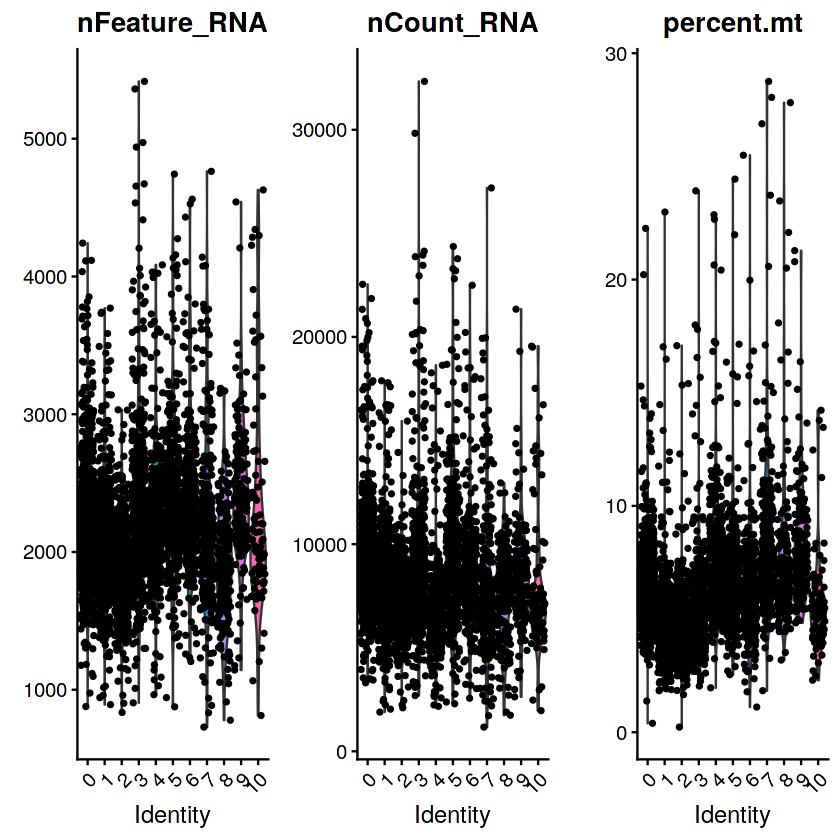

In [113]:
VlnPlot(scRNAsub, features = c("nFeature_RNA", "nCount_RNA", "percent.mt") )

## 非线性降维

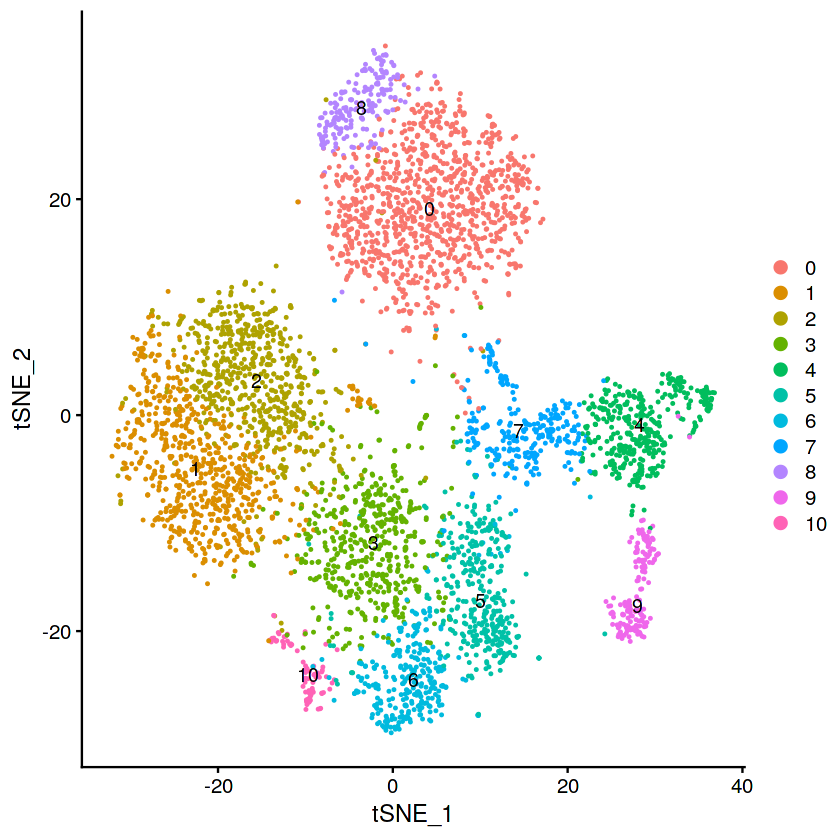

In [117]:
#tSNE
scRNAsub = RunTSNE(scRNAsub, dims = pc.num)
embed_tsne <- Embeddings(scRNAsub, 'tsne')
write.csv(embed_tsne, paste0(outputRoot,'01_subcluster_embed_tsne.csv') )

plot1 = DimPlot(scRNAsub, reduction = "tsne",label = TRUE)
print(plot1)
ggsave(paste0(outputRoot,"01_subcluster_tSNE.pdf"), plot = plot1, width = 8, height = 7)
#ggsave(paste0(outputRoot,"01_subcluster_tSNE.png"), plot = plot1, width = 8, height = 7)

In [118]:
#UMAP
scRNAsub <- RunUMAP(scRNAsub, dims = pc.num)
embed_umap <- Embeddings(scRNAsub, 'umap')
write.csv(embed_umap,paste0(outputRoot,'01_subcluster_embed_umap.csv') ) 

17:22:23 UMAP embedding parameters a = 0.9922 b = 1.112

17:22:23 Read 4641 rows and found 30 numeric columns

17:22:23 Using Annoy for neighbor search, n_neighbors = 30

17:22:23 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

17:22:23 Writing NN index file to temp file /tmp/RtmpwiH2i7/file79711bd1286f

17:22:23 Searching Annoy index using 1 thread, search_k = 3000

17:22:24 Annoy recall = 100%

17:22:24 Commencing smooth kNN distance calibration using 1 thread

17:22:25 Initializing from normalized Laplacian + noise

17:22:25 Commencing optimization for 500 epochs, with 196190 positive edges

17:22:29 Optimization finished



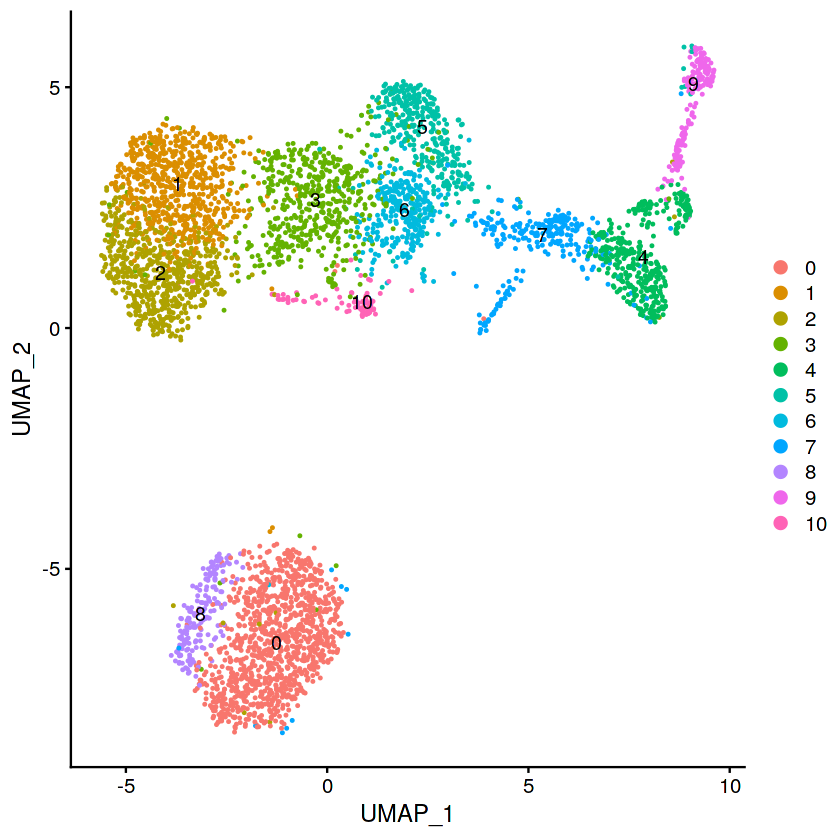

In [119]:
plot2 = DimPlot(scRNAsub, reduction = "umap",label = TRUE) 
print(plot2)
ggsave( paste0(outputRoot,"01_subcluster_UMAP.pdf"), plot = plot2, width = 8, height = 7)
#ggsave( paste0(outputRoot,"01_subcluster_UMAP.png"), plot = plot2, width = 8, height = 7)

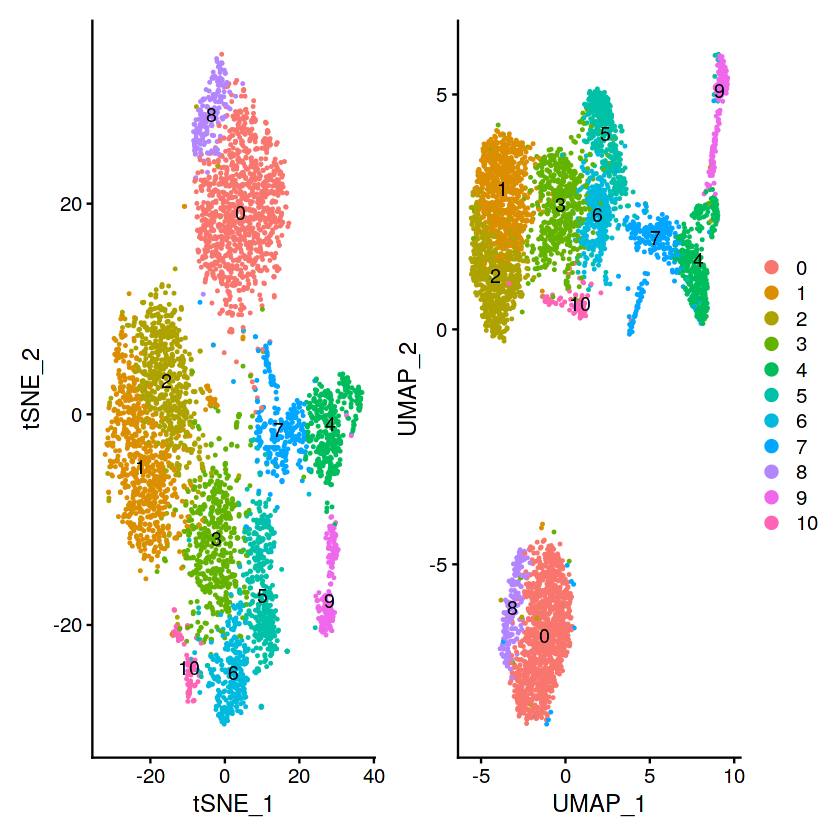

In [120]:
#合并tSNE与UMAP
plotc <- plot1+plot2+ plot_layout(guides = 'collect')
plotc
ggsave( paste0(outputRoot,"01_subcluster_tSNE_UMAP.pdf"), plot = plotc, width = 10, height = 5)

# Cluster差异分析

In [121]:
diff.wilcox = FindAllMarkers(scRNAsub) # about 5min;
all.markers = diff.wilcox %>% select(gene, everything()) %>% subset(p_val<0.05)

top10 = all.markers %>% group_by(cluster) %>% top_n(n = 10, wt = avg_logFC)
write.csv(all.markers, paste0(outputRoot,"02_subcluster_diff_genes_wilcox.csv"), row.names = F)
write.csv(top10, paste0(outputRoot,"02_subcluster_top10_diff_genes_wilcox.csv"), row.names = F)

Calculating cluster 0

Calculating cluster 1

Calculating cluster 2

Calculating cluster 3

Calculating cluster 4

Calculating cluster 5

Calculating cluster 6

Calculating cluster 7

Calculating cluster 8

Calculating cluster 9

Calculating cluster 10



## heatmap of cluster

png 
  2

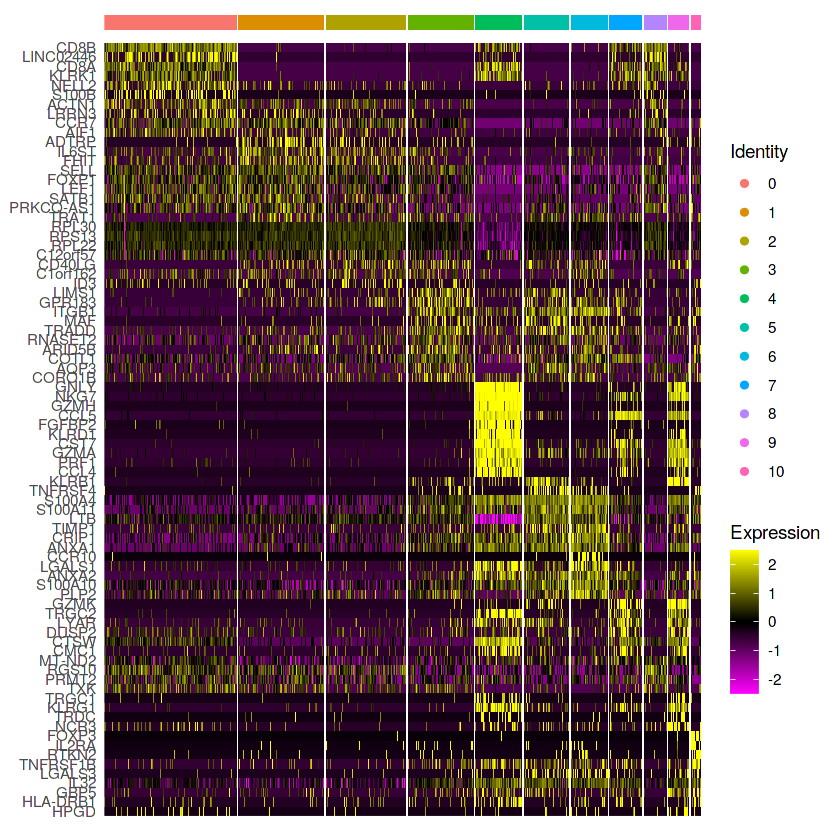

In [122]:
p1=DoHeatmap(scRNAsub, features = top10$gene, label = F )  #+ NoLegend()
print(p1)

pdf( paste0(outputRoot, "02_plot_DoHeatmap.pdf"), width=8, height=10)
print(p1)
dev.off()

In [123]:
top5 <- all.markers  %>% group_by(cluster) %>% top_n(n = 5, wt = avg_logFC)
dim(top5)

[1] 55  7

png 
  2

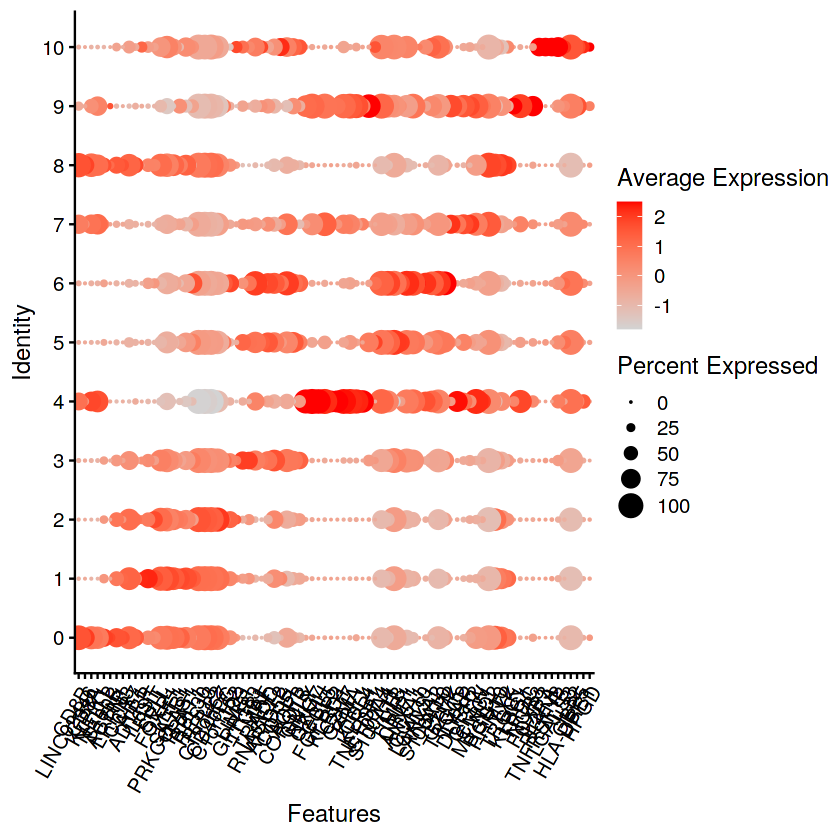

In [124]:
library(ggplot2)
p1=DotPlot(scRNAsub, features = rev(unique( top10$gene )), cols = c("lightgrey", "red") ) +
 theme( axis.text.x = element_text(angle = 60, vjust = 1, hjust = 1) )

print(p1)

pdf( paste0(outputRoot, "02_plot_DotPlot.pdf"), width=20, height=4)
print(p1)
dev.off()

### search gene names

In [125]:
searchGene=function(pattern="^CCN"){
    rownames( scRNAsub@assays$RNA)[ grep(pattern, rownames( scRNAsub@assays$RNA) ) ]
}
# test
searchGene()

[1] "CCNL2"     "CCNT2-AS1" "CCNT2"     "CCNYL1"    "CCNL1"     "CCNI"     
 [7] "CCNG2"     "CCNA2"     "CCNB1"     "CCNH"      "CCNI2"     "CCNJL"    
[13] "CCNG1"     "CCND3"     "CCNC"      "CCN6"      "CCN2"      "CCNE2"    
[19] "CCN3"      "CCNY"      "CCNJ"      "CCND1"     "CCND2-AS1" "CCND2"    
[25] "CCNT1"     "CCNB1IP1"  "CCNK"      "CCNDBP1"   "CCNB2"     "CCNF"     
[31] "CCNE1"     "CCN5"      "CCNB3"     "CCNQ"

png 
  2

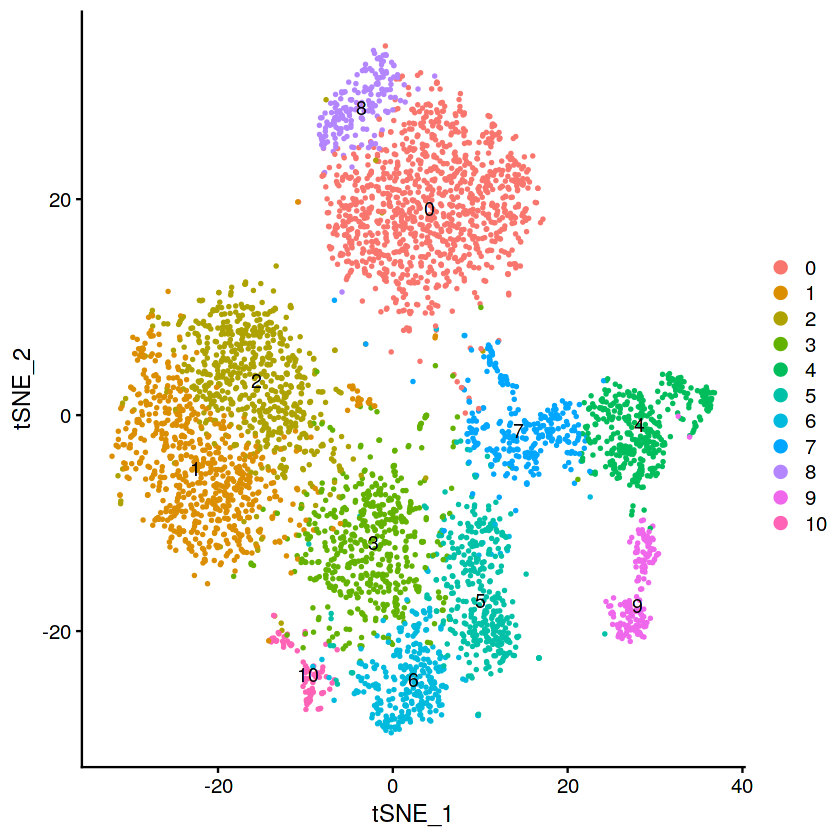

In [126]:
p1=DimPlot(scRNAsub, reduction = "tsne", label = TRUE, pt.size = 0.5) #+ NoLegend()
print(p1)

pdf( paste0(outputRoot, "03_plot_tSNE.pdf"), width=4.5, height=4)
print(p1)
dev.off()

## markers

### CD4 and CD8

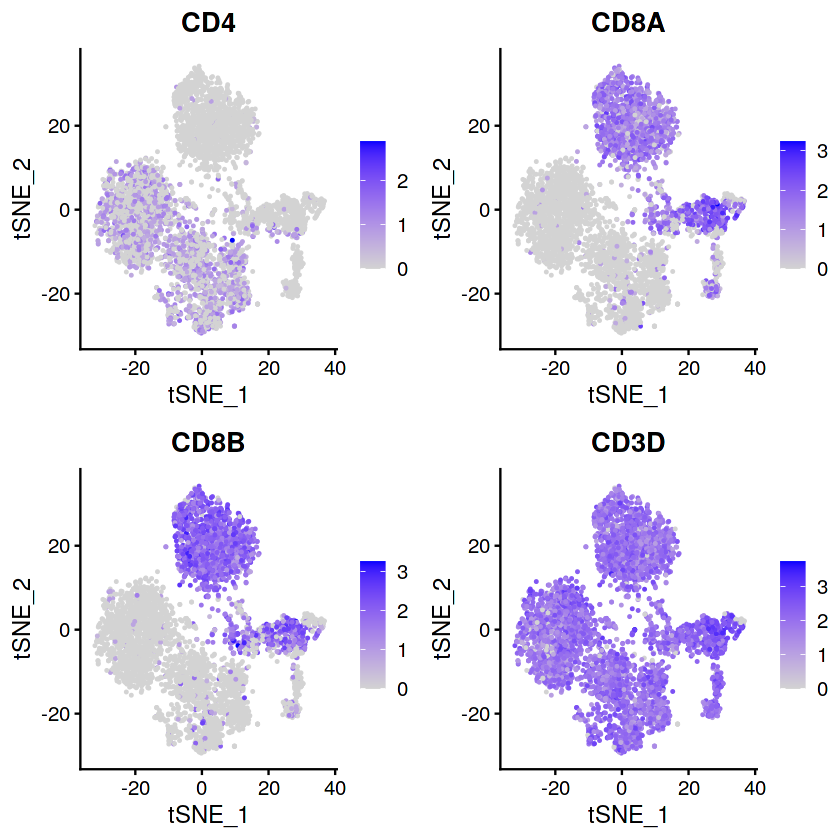

In [127]:
FeaturePlot(scRNAsub, features = c("CD4", "CD8A", "CD8B","CD3D"), reduction = "tsne")

* CD8: 0,8,  4,7,  9? 
* CD4: 1,2, 3,5,6, 10

In [128]:
searchGene("IFN")

[1] "IFNLR1"   "IFNGR1"   "IFNG-AS1" "IFNG"     "IFNL1"    "IFNAR2"   "IFNAR1"  
[8] "IFNGR2"

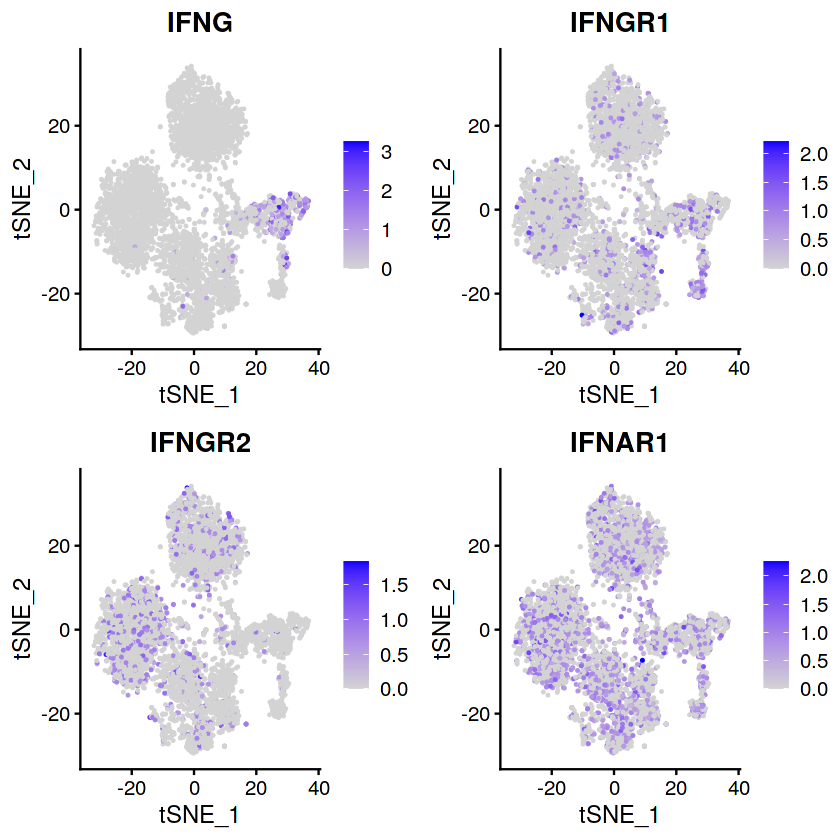

In [129]:
FeaturePlot(scRNAsub, features = c("IFNG", "IFNGR1", "IFNGR2","IFNAR1"), reduction = "tsne")

### GZM-

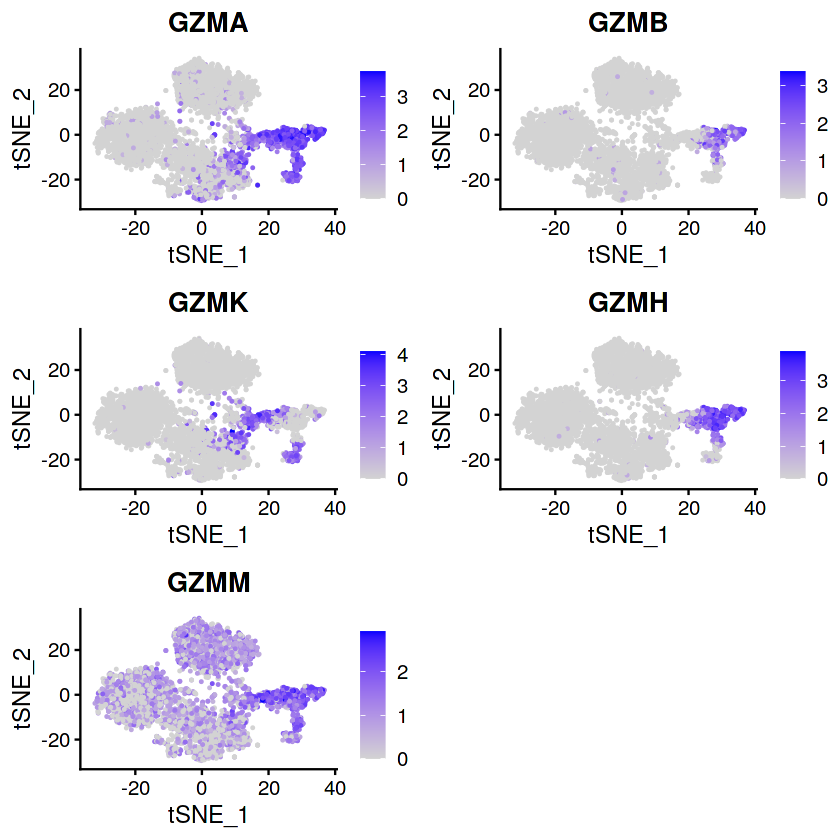

In [130]:
FeaturePlot(scRNAsub, features = c("GZMA","GZMB", "GZMK","GZMH", "GZMM"), reduction = "tsne")

### T reg

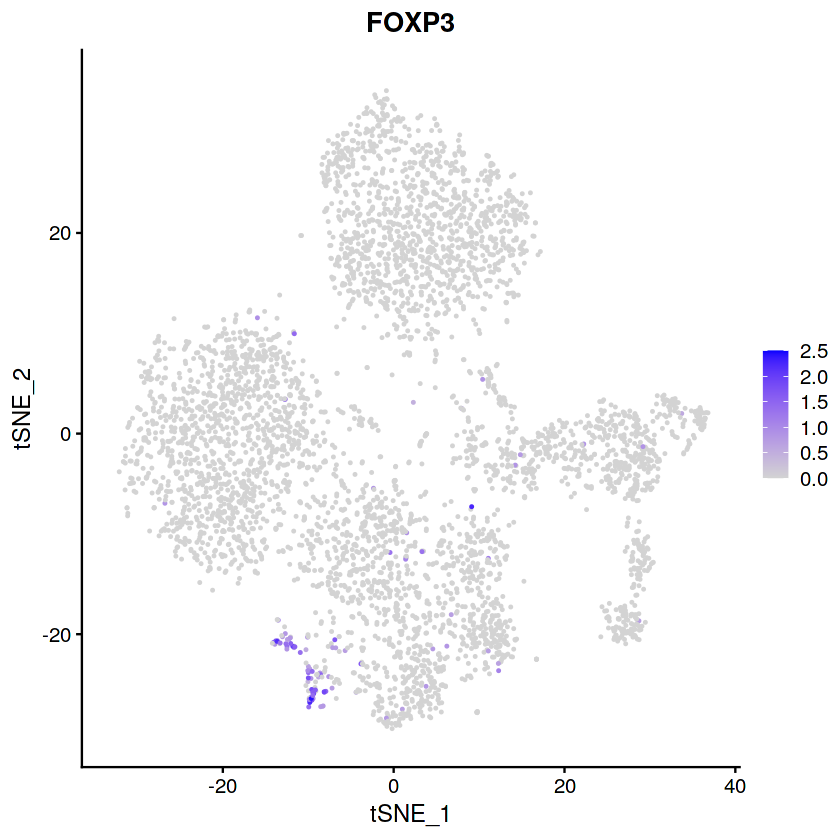

In [131]:
FeaturePlot(scRNAsub, features = c("FOXP3"), reduction = "tsne")
# 11

### cell cycle (no use)

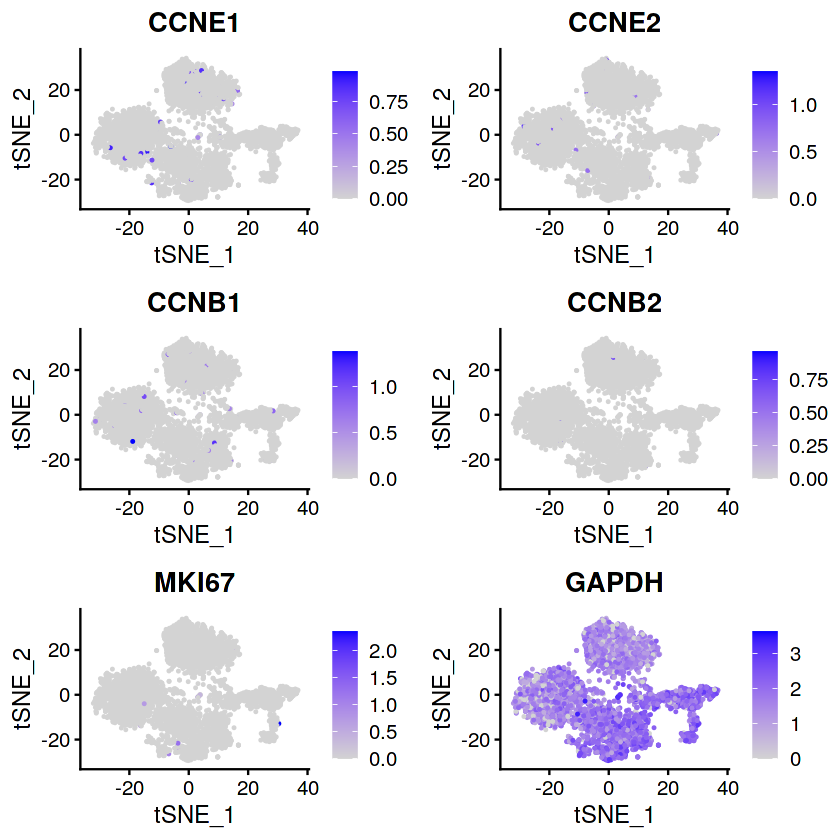

In [132]:
FeaturePlot(scRNAsub, features = c("CCNE1","CCNE2","CCNB1","CCNB2", "MKI67", 'GAPDH'), reduction = "tsne")

### IL-d (no use)

In [133]:
searchGene("^TNFA")

[1] "TNFAIP8L2" "TNFAIP6"   "TNFAIP8"   "TNFAIP3"   "TNFAIP2"   "TNFAIP8L3"
[7] "TNFAIP1"   "TNFAIP8L1"

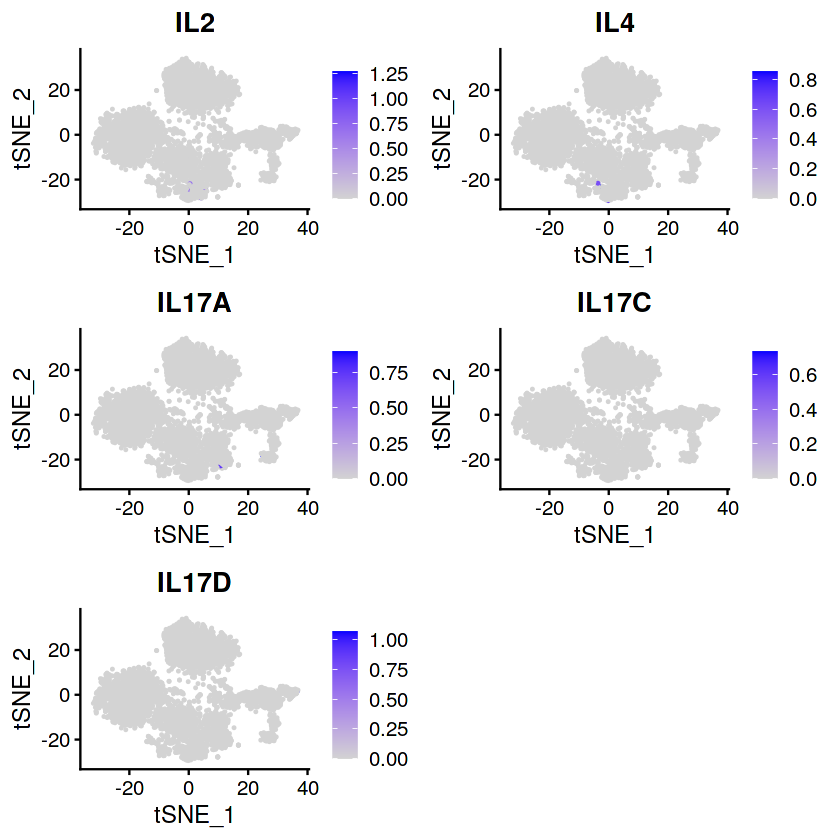

In [134]:
FeaturePlot(scRNAsub, features = c("IL2","IL4","IL17A","IL17C", 'IL17D'), reduction = "tsne")

### CCR7(naive marker)

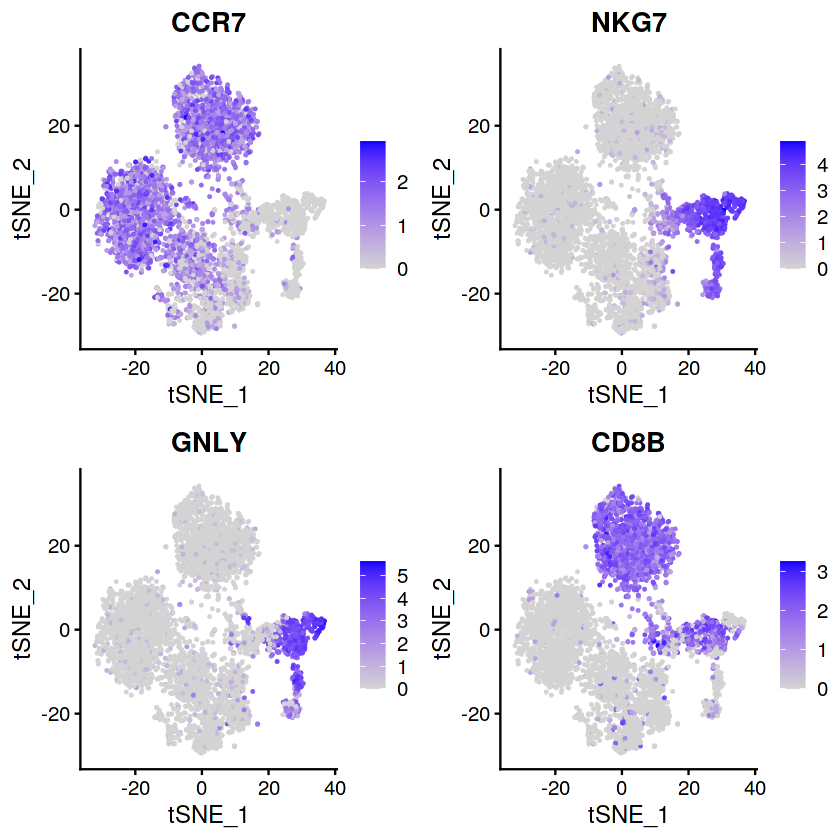

In [136]:
FeaturePlot(scRNAsub, features = c("CCR7", "NKG7", "GNLY", 'CD8B'), reduction = "tsne")

* no GNLY in 7

### CCL4 (todo)

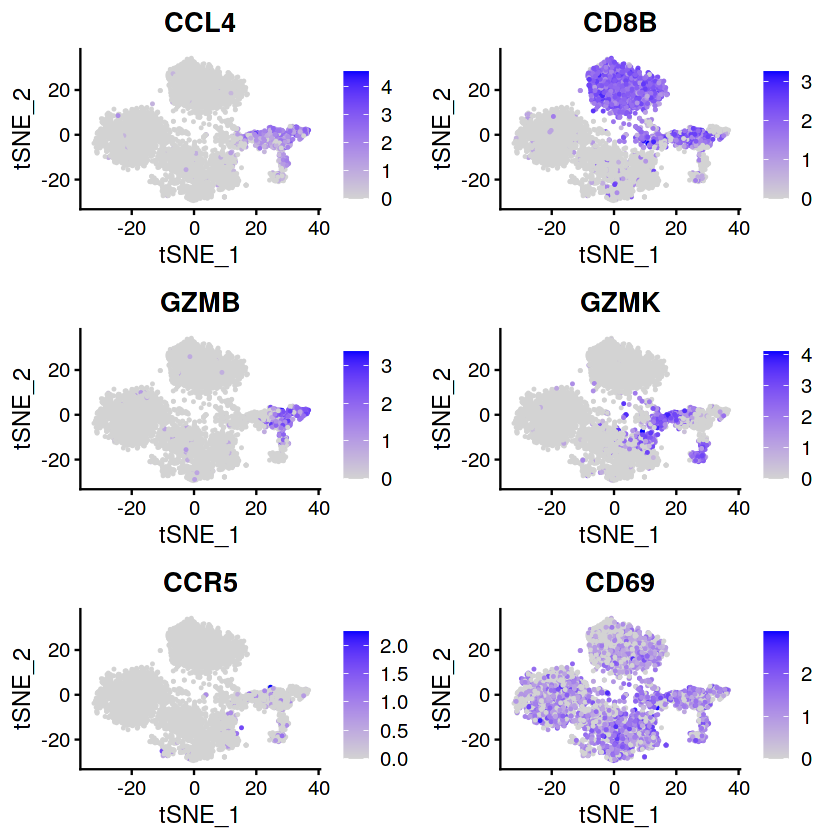

In [148]:
FeaturePlot(scRNAsub, features = c("CCL4", 'CD8B', 'GZMB','GZMK', "CCR5",'CD69'), reduction = "tsne")

In [173]:
searchGene("^CCL5")

[1] "CCL5"

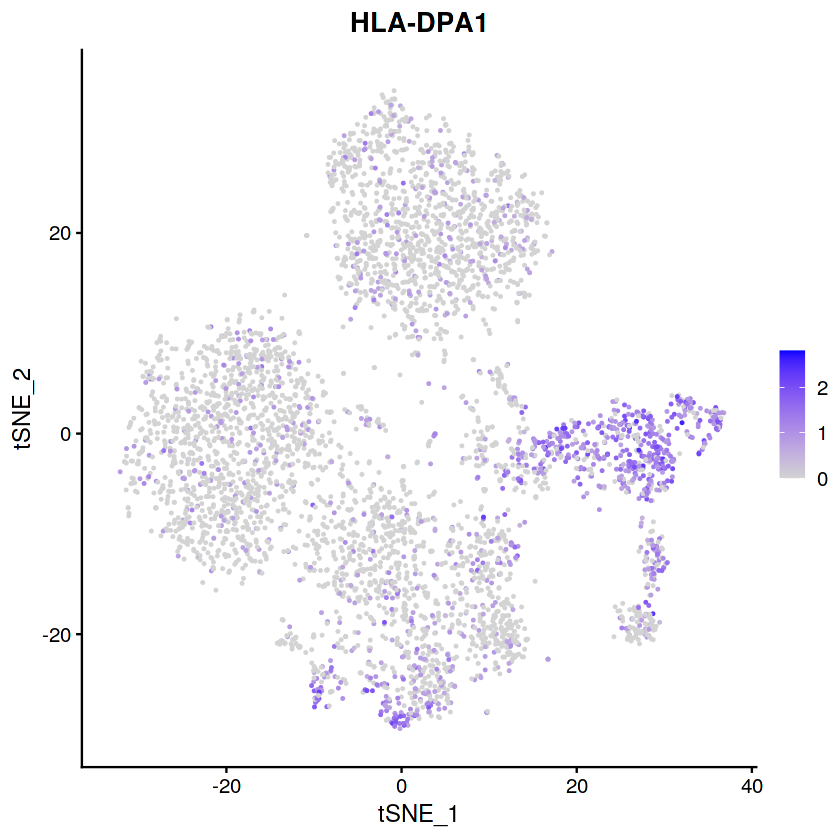

In [146]:
FeaturePlot(scRNAsub, features = c("HLA-DPA1"), reduction = "tsne")

### Th17 cell

* https://www.rndsystems.com/cn/resources/cell-markers/immune-cells/helper-t-cells/th17-cell-markers

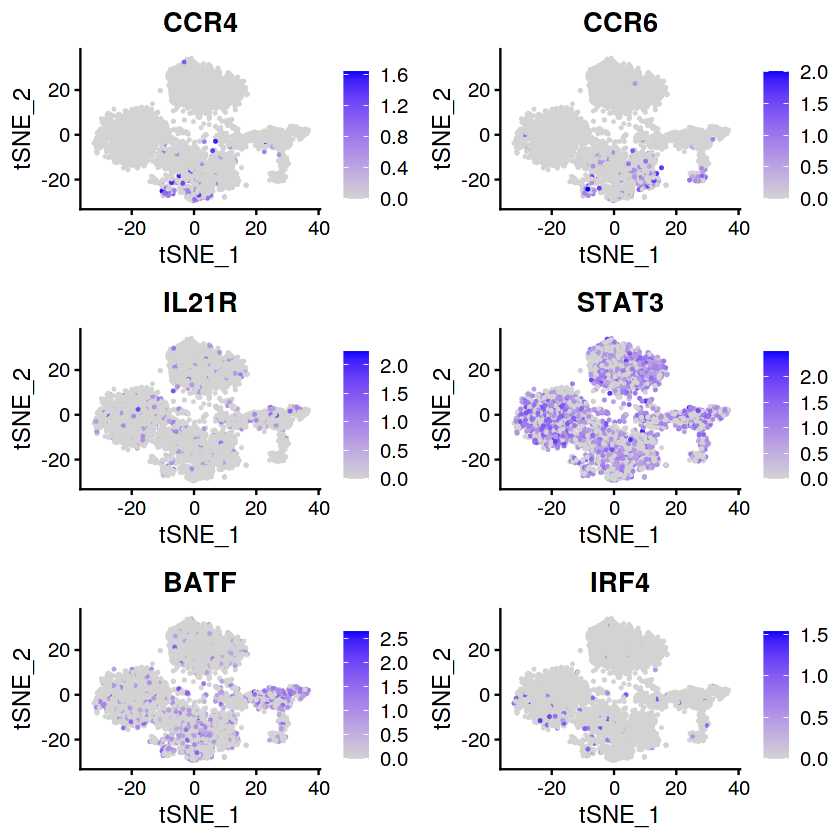

In [153]:
FeaturePlot(scRNAsub, features = c("CCR4","CCR6", "IL21R", "STAT3",'BATF','IRF4'), reduction = "tsne")

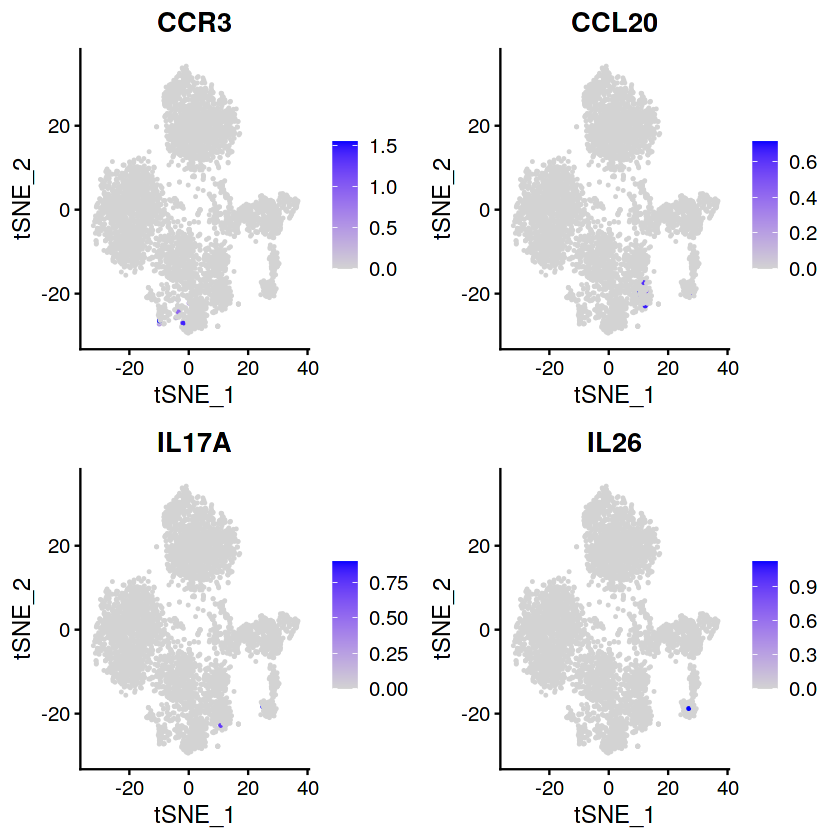

In [176]:
FeaturePlot(scRNAsub, features = c("CCR3","CCL20","IL17A","IL26"), reduction = "tsne")

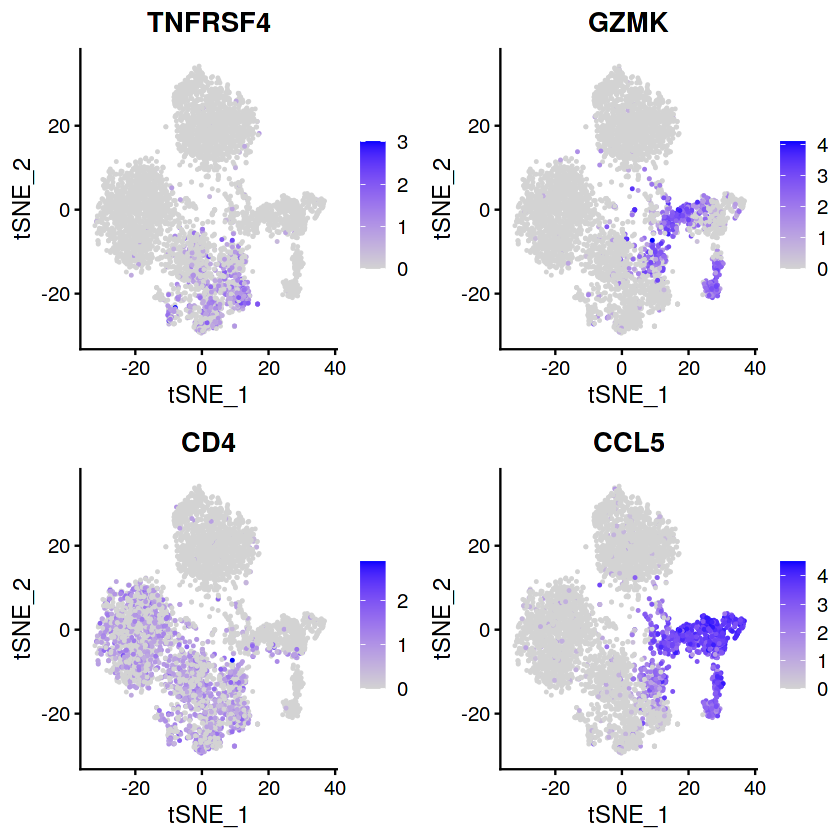

In [174]:
FeaturePlot(scRNAsub, features = c("TNFRSF4", "GZMK", 'CD4','CCL5'), reduction = "tsne") #5

## 细胞命名

In [189]:
cellTypes=(function(){
    rs=data.frame(
        cluster=seq(0,10),
        cellType=c("Naive CD8 T", #0
    "Naive CD4 T", #1
    "Naive CD4 T",  #2
    "Naive CD4 T-LMS1", #3
    "CTL-IFNG", #4
                   
    "CD4 T-GZMK", #5
    "CD4 T",  #6
    "CTL-GZMK", #7
    "Naive CD8 T",  #8
    "CTL-GNLY", #9
                   
    "CD4 Treg" #10
      )
    )
    rs$one=paste0(rs$cluster,"-", rs$cellType)
    rs
})()
cellTypes

cluster cellType         one               
1   0      Naive CD8 T      0-Naive CD8 T     
2   1      Naive CD4 T      1-Naive CD4 T     
3   2      Naive CD4 T      2-Naive CD4 T     
4   3      Naive CD4 T-LMS1 3-Naive CD4 T-LMS1
5   4      CTL-IFNG         4-CTL-IFNG        
6   5      CD4 T-GZMK       5-CD4 T-GZMK      
7   6      CD4 T            6-CD4 T           
8   7      CTL-GZMK         7-CTL-GZMK        
9   8      Naive CD8 T      8-Naive CD8 T     
10  9      CTL-GNLY         9-CTL-GNLY        
11 10      CD4 Treg         10-CD4 Treg

In [190]:
new.cluster.ids=as.character(cellTypes$cellType)
names(new.cluster.ids) <- levels(scRNAsub)
new.cluster.ids

0                  1                  2                  3 
     "Naive CD8 T"      "Naive CD4 T"      "Naive CD4 T" "Naive CD4 T-LMS1" 
                 4                  5                  6                  7 
        "CTL-IFNG"       "CD4 T-GZMK"            "CD4 T"         "CTL-GZMK" 
                 8                  9                 10 
     "Naive CD8 T"         "CTL-GNLY"         "CD4 Treg"

In [192]:
scRNAsub2 <- RenameIdents(scRNAsub, new.cluster.ids)
levels(scRNAsub2@active.ident)

[1] "Naive CD8 T"      "Naive CD4 T"      "Naive CD4 T-LMS1" "CTL-IFNG"        
[5] "CD4 T-GZMK"       "CD4 T"            "CTL-GZMK"         "CTL-GNLY"        
[9] "CD4 Treg"

png 
  2

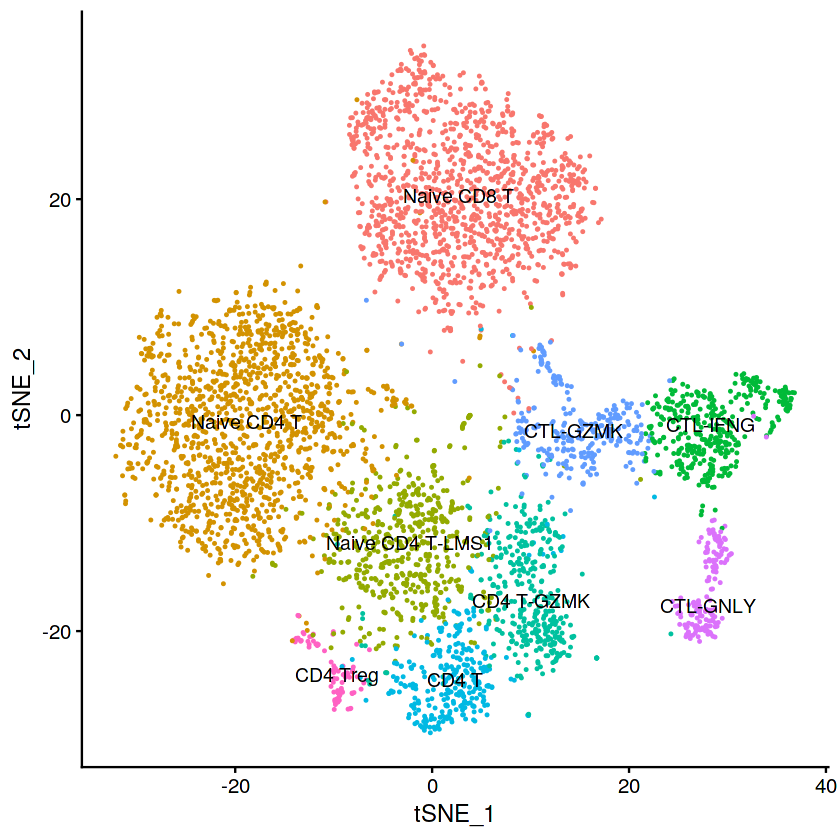

In [193]:
p1=DimPlot(scRNAsub2, reduction = 'tsne', label = T) + NoLegend()
print(p1)


pdf( paste0(outputRoot, "04_plot_tSNE-withCellName.pdf"), width=5, height=4.5)
print(p1)
dev.off()

### save

In [194]:
saveRDS(scRNAsub2, file = paste0(outputRoot,"pbmc10k-Tsubset_final.rds") ) #long time: 2min